Updated November 25. Designs probes against a region antisense to the tandem array where there most likely are lncRNAs. Blasts against transcriptome with introns, transcriptome without introns, and intergenic databases to verify specificity. 
Author: Giacomo Glotzer. 

In [46]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import subprocess
import sys
sys.path.append('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/analysis')
from transcriptomics import * 
from hcr import *
from plotting import * 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# Specify blast databases
new_transcriptome_db_no_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_no_introns/mRNA_no_introns"
new_transcriptome_db_yes_introns = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/mRNA_yes_introns/mRNA_yes_introns"
all_intergenic_regions_db = "/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/intergenics/all_intergenic_regions"
all_lncRNAs_db = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/lncRNAs/all_ORs_antisense'

# Load genome
genome_fasta_path = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/OR List.xlsx') 

In [47]:
# set main directory for writing files 
main_directory = '/Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/single_lncRNA_probe_design/'

In [48]:
TA = 70

In [49]:
class lncRNA():
    def __init__(self, chromosome, start, end, strand, target_sequence):
        self.start = start
        self.end = end
        self.chromosome = chromosome
        self.strand = strand
        self.target_sequence = target_sequence
        self.name = f"lncRNA_{chromosome}-{start}-{end}_{strand}"

In [50]:
start_gene, end_gene = "Or5-Q1", "Or5-Q1"
chromosome = tr.get_gene(start_gene).get_transcript_longest_bounds().chromosome
start = tr.get_gene(start_gene).get_transcript_longest_bounds().get_bounds()[0]
end = tr.get_gene(end_gene).get_transcript_longest_bounds().get_bounds()[1]
strand = "-" if tr.get_gene(start_gene).get_transcript_longest_bounds().strand == "+" else "+" 

target_sequence = get_sequence(genome_seq, chromosome, start, end, strand)
print(f"{chromosome}:{start}-{end} ({strand})")

Chr1:6511625-6514800 (+)


In [51]:
my_lnc = lncRNA(chromosome, start, end, strand, target_sequence)
my_lnc.name

'lncRNA_Chr1-6511625-6514800_+'

In [55]:
# Permitted off-targets
permitted_off_targets = ['Or5-Q1-lnc']

In [56]:
# Export each gene sequence to a fasta file 
output_dir = os.path.join(main_directory, 'or_seq_blast_input')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

with open(f"{output_dir}/{my_lnc.name}.fasta", 'w') as f: 
    f.write(f">{my_lnc.name}\n{my_lnc.target_sequence}")

In [57]:
## Blast genes against the transcriptome without introns (mature mRNA), transcriptome with introns (pre-mRNA), and intergenic regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_input')
output_dir = os.path.join(main_directory, 'or_seq_blast_output')

# create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# get gene sequence path 
input_path = f"{input_dir}/{my_lnc.name}.fasta"
# no introns 
output_path = f"{output_dir}/{my_lnc.name}_blasted_no_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# yes introns
output_path = f"{output_dir}/{my_lnc.name}_blasted_yes_introns.csv"
command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -5 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# intergenic 
output_path = f"{output_dir}/{my_lnc.name}_blasted_intergenics.csv"
command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)
# lncRNA 
output_path = f"{output_dir}/{my_lnc.name}_blasted_lncRNAs.csv"
command = f"blastn -task blastn -query {input_path} -db {all_lncRNAs_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -strand plus -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
subprocess.run(command, shell=True, check=True)

CompletedProcess(args="blastn -task blastn -query /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/single_lncRNA_probe_design/or_seq_blast_input/lncRNA_Chr1-6511625-6514800_+.fasta -db /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/transcriptome/lncRNAs/all_ORs_antisense -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -strand plus -soft_masking false -max_target_seqs 10000 -out /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/single_lncRNA_probe_design/or_seq_blast_output/lncRNA_Chr1-6511625-6514800_+_blasted_lncRNAs.csv -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4", returncode=0)

In [58]:
length_thresh = 50 

## Iterate through blast results and annotate non-unique regions 
input_dir = os.path.join(main_directory, 'or_seq_blast_output')
output_dir = os.path.join(main_directory, 'or_seq_unique_regions') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# No introns
input_path = f"{input_dir}/{my_lnc.name}_blasted_no_introns.csv"
blast_results_no_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_no_introns['source'] = 'no_introns'

# Yes introns
input_path = f"{input_dir}/{my_lnc.name}_blasted_yes_introns.csv"
blast_results_yes_introns = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_yes_introns['source'] = 'yes_introns'

# Intergenics 
input_path = f"{input_dir}/{my_lnc.name}_blasted_intergenics.csv"
blast_results_intergenics = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_intergenics['source'] = 'intergenics'

# lncRNAs 
input_path = f"{input_dir}/{my_lnc.name}_blasted_lncRNAs.csv"
blast_results_lncRNAs = pd.read_csv(input_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
blast_results_lncRNAs['source'] = 'lncRNAs'

# Concatenate 
blast_results = pd.concat([blast_results_no_introns, blast_results_yes_introns, blast_results_intergenics, blast_results_lncRNAs], axis=0)
blast_results = blast_results.reset_index(drop=True)

# remove rows where length < length_thresh 
blast_results = blast_results.loc[(blast_results['length'].values >= length_thresh), :]
blast_results = blast_results.reset_index(drop=True)

# Add column for subject gene ID 
blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

# permitted_off_targets 
blast_results['permitted_off_target'] = blast_results.apply(
    lambda x: any([keyword in x['subject_id'] for keyword in permitted_off_targets]),
    axis=1
)

# Get off-targets
off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['permitted_off_target'] == False), :]  # ignore overlapping intergenics 

# Annotate off-targets 
sequence = my_lnc.target_sequence
for j, row in off_targets.iterrows():
    sequence = sequence[:row['q_start']] + '-'*(row['q_end'] - row['q_start']) + sequence[row['q_end']:]
my_lnc.unique_sequence = sequence 

# Save the blast results to the gene object 
my_lnc.blast_results = blast_results

# Save the sequence to new file 
with open(f"{output_dir}/{my_lnc.name}_unique.fasta", 'w') as f:
    f.write(f">{my_lnc.name}\n")
    f.write(sequence)

print(f"Unique regions have been annotated and exported to {output_dir}")

Unique regions have been annotated and exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/single_lncRNA_probe_design/or_seq_unique_regions


In [59]:
off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,permitted_off_target


In [60]:
blast_results

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,permitted_off_target
0,lncRNA_Chr1-6511625-6514800_+,Or5-Q1-lnc,Or5-Q1-lnc,100.0,3175,0,0,1,3175,1,3175,0.0,6347.0,lncRNAs,None,True


In [61]:
# Determine how many probes fit on each gene 
sequence = my_lnc.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, "B1")

print(f"There is enough space for {len(probes)} probes in {my_lnc.name}")

There is enough space for 35 probes in lncRNA_Chr1-6511625-6514800_+


In [63]:
# Specify amplifier 
amplifier = "B2"

In [64]:
# Specify how many probes 
n_probes = 30

In [65]:
# Export excel sheet with probes and excel sheet with probe binding regions 

# Design probes
sequence = my_lnc.unique_sequence 
probes, regions, positions = design_hcr_probes(sequence, amplifier)

# Randomly select n_probes_per_gene probes 
np.random.seed(1)
if len(probes) < n_probes:
    indices = range(len(probes))
else: 
    indices = np.random.choice(range(len(probes)), n_probes, replace=False)
probes = [probes[i] for i in indices]
regions = [regions[i] for i in indices]

# Save probes and regions to gene object
my_lnc.probes = probes
my_lnc.regions = regions

# Collapse probes 
probes_collapsed = [probe for sublist in probes for probe in sublist]

# Get date 
today = pd.Timestamp.now().strftime('%Y-%m-%d')

# Export probes 
output_dir = os.path.join(main_directory, 'IDT_sheets')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{my_lnc.name}_{amplifier}_{today}.xlsx"
# Create dataframe
df = pd.DataFrame({'Sequence': probes_collapsed})
# Add pool name column 
df['Pool name'] = f'{my_lnc.name}_{amplifier}'
df = df[['Pool name', 'Sequence']]
df.to_excel(output_path, index=False)
print(f"{len(probes_collapsed)} probes have been exported to {output_path}")


# Export probe binding regions
output_dir = os.path.join(main_directory, 'probe_binding_regions_sheets') 
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Create output path
output_path = f"{output_dir}/{my_lnc.name}_{amplifier}_regions_{today}.xlsx"
# Make a vector of the gene names for each probe 
target_genes = [my_lnc.name for _ in range(len(probes))]
df = pd.DataFrame({'Gene': [my_lnc.name for _ in range(len(probes))], 
                   'Region': regions, 
                   'Probe 1': [probe[0] for probe in my_lnc.probes], 
                   'Probe 2': [probe[1] for probe in my_lnc.probes]})
df.to_excel(output_path, index=False)

60 probes have been exported to /Users/giacomo.glotzer/Desktop/Rockefeller/Kronauer/Analysis/hcr-probe-design/single_lncRNA_probe_design/IDT_sheets/lncRNA_Chr1-6511625-6514800_+_B2_2025-01-25.xlsx


In [66]:
# Export all_regions to individual fasta files 

output_dir = os.path.join(main_directory, 'probe_region_blast_input')
# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Export all_regions to individual fasta files in output_dir 
for i, region in enumerate(regions): 
    with open(f"{output_dir}/region-{i}.fasta", 'w') as f: 
        f.write(f">region-{i}\n{region}")

In [67]:
# Blast all regions against the transcriptome

input_dir = os.path.join(main_directory, 'probe_region_blast_input')
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clear contents of the output directory
for file in os.listdir(output_dir):
    os.remove(f"{output_dir}/{file}")

# Blast each region against the transcriptome
for i, region in enumerate(regions): 
    input_path = f"{input_dir}/region-{i}.fasta"

    # Blast against transcriptome without introns
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_no_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against transcriptome with introns
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    command = f"blastn -task blastn -query {input_path} -db {new_transcriptome_db_yes_introns} -ungapped -word_size 15 -reward 1 -penalty -1 -strand plus -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against intergenics 
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_intergenic_regions_db} -ungapped -word_size 15 -reward 1 -penalty -1 -dust no -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

    # Blast against lncRNAs
    output_path = f"{output_dir}/region-{i}-blasted_lncRNAs.csv"
    command = f"blastn -task blastn -query {input_path} -db {all_lncRNAs_db} -ungapped -word_size 15 -reward 1 -penalty -5 -dust no -strand plus -soft_masking false -max_target_seqs 10000 -out {output_path} -outfmt '10 qseqid sseqid sacc pident length mismatch gapopen qstart qend sstart send evalue bitscore' -num_threads 4"
    subprocess.run(command, shell=True, check=True)

print("All regions have been blasted against the transcriptome")

All regions have been blasted against the transcriptome


In [68]:
# Load in blast results
output_dir = os.path.join(main_directory, 'probe_region_blast_output') 
all_blast_results = []
for i, region in enumerate(regions):
    output_path = f"{output_dir}/region-{i}-blasted_no_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'no_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_yes_introns.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'yes_introns'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_intergenics.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'intergenics'
    all_blast_results.append(blast_results)
    output_path = f"{output_dir}/region-{i}-blasted_lncRNAs.csv"
    blast_results = pd.read_csv(output_path, header=None, names=['query_id', 'subject_id', 'subject_acc', 'percent_identity', 'length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bitscore'])
    blast_results['source']  = 'lncRNAs'
    all_blast_results.append(blast_results)

In [69]:
# Check for non-unique regions

num_hits_over_thresh = 0
length_thresh = 50
mismatch_thresh = 5 
all_off_targets = pd.DataFrame()

# Iterate through blast results 
for i, blast_results in enumerate(all_blast_results):
    if len(blast_results) == 0: 
        continue

    # Add column for subject gene ID 
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: tr.get_gene_from_transcript(x['subject_acc']), axis=1)
    blast_results['subject_gene_id'] = blast_results.apply(lambda x: x['subject_gene_id'] if x['subject_gene_id'] != None else tr.get_gene_from_transcript(x['subject_id']), axis=1)

    # permitted_off_targets
    blast_results['permitted_off_target'] = blast_results.apply(
        lambda x: any([keyword in x['subject_id'] for keyword in permitted_off_targets]),
        axis=1
    )

    # Get off-targets
    off_targets = blast_results.loc[(blast_results['length'].values >= length_thresh) & # length threshold, no need for mismatch threshold here 
                                    (blast_results['mismatches'].values <= mismatch_thresh) & # mismatch threshold
                                    (blast_results['permitted_off_target'] == False), :]  # ignore overlapping intergenics 
    
    
    # Add to the all_off_targets dataframe
    all_off_targets = pd.concat([all_off_targets, off_targets])

    # Update num_hits_over_thresh   
    num_hits_over_thresh += len(off_targets)

print(f"Found {num_hits_over_thresh} off-target hits with length >= {length_thresh}bp, mismatches <= {mismatch_thresh}")

Found 0 off-target hits with length >= 50bp, mismatches <= 5


In [70]:
all_off_targets

,query_id,subject_id,subject_acc,percent_identity,length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,source,subject_gene_id,permitted_off_target


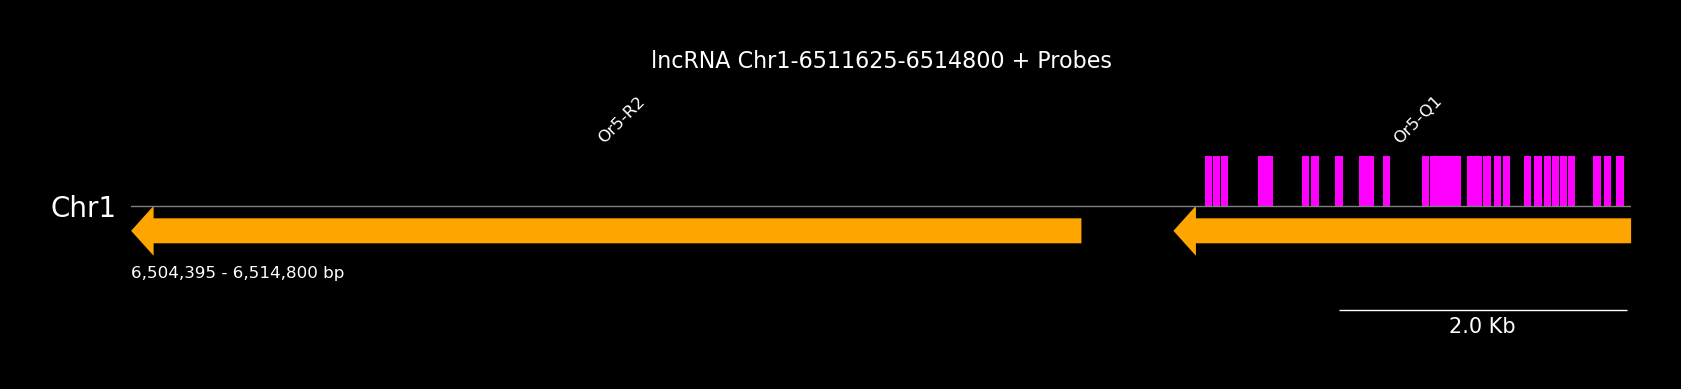

In [71]:
black_plotting()
gv = GenomeViz(track_align_type="center", theme="dark")
gv.set_scale_bar(ymargin=0.5)

# Get genes 
genes = or_db[or_db['tandem_array'] == TA]['gene_name'].values
# Get gene objects from tr 
gene_objects = [tr.get_gene(gene) for gene in genes]

# Get bounds 
chromosome = gene_objects[0].chromosome
bounds = [gene_object.get_transcript_longest_bounds().get_bounds() for gene_object in gene_objects]
min_start = int(np.min(bounds))
max_end = int(np.max(bounds))
track = gv.add_feature_track(chromosome, segments = (min_start, max_end))
track.add_sublabel()

# Add gene models to plot 
for gene in gene_objects:
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    track.add_feature(int(bounds[0]), int(bounds[1]), strand, plotstyle='arrow', arrow_shaft_ratio = 0.5, label=gene.name)

# Get the region of the genome 
forward_seq = str(genome_seq[chromosome].seq[min_start:max_end]).upper()

# Add probe regions to plot on opposite strand 
for region in regions:
    positions = [m.start() for m in re.finditer(region, forward_seq)]
    for position in positions:
        track.add_feature(min_start + position, min_start + position + len(region), 1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

# Add reverse complement 
reverse_seq = reverse_complement(forward_seq)
for region in regions:
    positions = [m.start() for m in re.finditer(region, reverse_seq)]
    for position in positions:
        track.add_feature(max_end - position - len(region), max_end - position, -1, plotstyle="box", label = '', ec="none", fc="magenta", alpha=1)

fig = gv.plotfig()

name = re.sub('_', ' ', my_lnc.name)
plt.title(f"{name} Probes", y=1.8, fontsize=16)
plt.show()

# Export figure 
output_dir = os.path.join(main_directory, 'probe_regions_plot')

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save figure
output_path = f"{output_dir}/{my_lnc.name}_{amplifier}_probes.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)

